In [ ]:
# CELL 1: SETUP AND ENVIRONMENT CHECK
# =============================================================================

# Check GPU availability and install packages
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Install required packages
!pip install kagglehub -q

# Import all required libraries
import kagglehub
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("✅ All libraries imported successfully!")


TensorFlow Version: 2.19.0
GPU Available: []
✅ All libraries imported successfully!


In [ ]:
# CELL 2: DOWNLOAD AND EXPLORE DATASET
# =============================================================================

# Download dataset
path = kagglehub.dataset_download("riyaelizashaju/skin-disease-classification-image-dataset")
print("Path to dataset files:", path)

# Explore dataset structure
print("\n📁 Dataset structure:")
for root, dirs, files in os.walk(path):
    level = root.replace(path, '').count(os.sep)
    if level < 3:  # Don't go too deep
        indent = '  ' * level
        print(f'{indent}{os.path.basename(root)}/')
        if level == 2:  # Show file counts in class folders
            print(f'{indent}  📊 {len(files)} images')

# Set dataset paths
train_dir = f'{path}/Split_smol/train'
val_dir = f'{path}/Split_smol/val'

print(f"\n✅ Train directory: {train_dir}")
print(f"✅ Validation directory: {val_dir}")

# Count classes and images
train_classes = os.listdir(train_dir)
val_classes = os.listdir(val_dir)
print(f"\n🏷️ Number of classes: {len(train_classes)}")
print(f"📋 Classes: {train_classes}")


Using Colab cache for faster access to the 'skin-disease-classification-image-dataset' dataset.
Path to dataset files: /kaggle/input/skin-disease-classification-image-dataset

📁 Dataset structure:
skin-disease-classification-image-dataset/
  Split_smol/
    val/
      📊 0 images
    train/
      📊 0 images

✅ Train directory: /kaggle/input/skin-disease-classification-image-dataset/Split_smol/train
✅ Validation directory: /kaggle/input/skin-disease-classification-image-dataset/Split_smol/val

🏷️ Number of classes: 9
📋 Classes: ['Tinea Ringworm Candidiasis', 'Melanoma', 'Vascular lesion', 'Melanocytic nevus', 'Atopic Dermatitis', 'Actinic keratosis', 'Squamous cell carcinoma', 'Benign keratosis', 'Dermatofibroma']


In [ ]:
# CELL 3: DATA PREPROCESSING FUNCTIONS
# =============================================================================

def create_data_generators(train_dir, val_dir, img_size=(224, 224), batch_size=32):
    """Create data generators with preprocessing and augmentation"""

    # Training data generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False,
        brightness_range=[0.8, 1.2],
        zoom_range=0.1,
        fill_mode='nearest'
    )

    # Validation data generator (only rescaling)
    val_datagen = ImageDataGenerator(rescale=1./255)

    # Create generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator

print("✅ Data preprocessing functions defined!")

✅ Data preprocessing functions defined!


In [ ]:
# CELL 4: MODEL 1 - RESNET50 TRANSFER LEARNING
# =============================================================================

def create_resnet50_model(num_classes, img_size=(224, 224, 3)):
    """Create ResNet50 transfer learning model"""

    # Load pre-trained ResNet50
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=img_size
    )

    # Freeze initial layers (fine-tune only top layers)
    for layer in base_model.layers[:-20]:  # Freeze all except last 20 layers
        layer.trainable = False

    # Add custom classification head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

print("✅ ResNet50 model function defined!")

✅ ResNet50 model function defined!


In [ ]:
# CELL 5: MODEL 2 - CUSTOM CNN WITH ATTENTION
# =============================================================================

def spatial_attention_block(input_tensor):
    """Spatial attention mechanism"""
    # Average and max pooling across channels
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)

    # Concatenate and apply convolution
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = layers.Conv2D(1, 7, padding='same', activation='sigmoid')(concat)

    # Apply attention weights
    return layers.Multiply()([input_tensor, attention])

def channel_attention_block(input_tensor, ratio=16):
    """Channel attention mechanism"""
    channels = input_tensor.shape[-1]

    # Global average and max pooling
    avg_pool = layers.GlobalAveragePooling2D()(input_tensor)
    max_pool = layers.GlobalMaxPooling2D()(input_tensor)

    # Shared MLP
    shared_dense1 = layers.Dense(channels // ratio, activation='relu')
    shared_dense2 = layers.Dense(channels, activation='sigmoid')

    avg_out = shared_dense2(shared_dense1(avg_pool))
    max_out = shared_dense2(shared_dense1(max_pool))

    # Add and reshape
    attention = layers.Add()([avg_out, max_out])
    attention = layers.Reshape((1, 1, channels))(attention)

    # Apply attention weights
    return layers.Multiply()([input_tensor, attention])

def create_custom_cnn_attention_model(num_classes, img_size=(224, 224, 3)):
    """Create custom CNN with attention mechanism"""

    inputs = layers.Input(shape=img_size)

    # First Conv Block
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)

    # Second Conv Block
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)

    # Third Conv Block with Attention
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Apply Channel Attention
    x = channel_attention_block(x)
    # Apply Spatial Attention
    x = spatial_attention_block(x)

    x = layers.MaxPooling2D(2)(x)

    # Fourth Conv Block
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)

    # Classification Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

print("✅ Custom CNN with Attention model function defined!")

✅ Custom CNN with Attention model function defined!


In [ ]:
# CELL 6: TRAINING AND EVALUATION FUNCTIONS
# =============================================================================

def train_model(model, train_generator, val_generator, model_name, epochs=50):
    """Train a model with callbacks and return history"""

    # Compile model
    if 'resnet' in model_name.lower():
        learning_rate = 0.0001  # Lower LR for transfer learning
    else:
        learning_rate = 0.001   # Higher LR for custom model

    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        ModelCheckpoint(
            f'best_{model_name.lower().replace(" ", "_")}_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train model
    print(f"\n{'='*50}")
    print(f"🚀 Training {model_name}")
    print(f"{'='*50}")

    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=callbacks,
        verbose=1
    )

    return history

def evaluate_model(model, val_generator, model_name):
    """Evaluate model and print metrics"""

    print(f"\n🔍 Evaluating {model_name}...")

    # Get predictions
    val_generator.reset()
    predictions = model.predict(val_generator, verbose=1)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = val_generator.classes
    class_names = list(val_generator.class_indices.keys())

    # Calculate metrics
    print(f"\n{'='*60}")
    print(f"📊 {model_name} - Classification Report")
    print(f"{'='*60}")
    print(classification_report(true_classes, predicted_classes,
                              target_names=class_names, digits=4))

    # Confusion Matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return predictions, predicted_classes

def plot_training_history(history1, history2, model1_name, model2_name):
    """Plot training history comparison"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0, 0].plot(history1.history['accuracy'], label=f'{model1_name} Train', linewidth=2)
    axes[0, 0].plot(history1.history['val_accuracy'], label=f'{model1_name} Val', linewidth=2)
    axes[0, 0].plot(history2.history['accuracy'], label=f'{model2_name} Train', linewidth=2)
    axes[0, 0].plot(history2.history['val_accuracy'], label=f'{model2_name} Val', linewidth=2)
    axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Loss
    axes[0, 1].plot(history1.history['loss'], label=f'{model1_name} Train', linewidth=2)
    axes[0, 1].plot(history1.history['val_loss'], label=f'{model1_name} Val', linewidth=2)
    axes[0, 1].plot(history2.history['loss'], label=f'{model2_name} Train', linewidth=2)
    axes[0, 1].plot(history2.history['val_loss'], label=f'{model2_name} Val', linewidth=2)
    axes[0, 1].set_title('Model Loss Comparison', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Precision
    axes[1, 0].plot(history1.history['precision'], label=f'{model1_name} Train', linewidth=2)
    axes[1, 0].plot(history1.history['val_precision'], label=f'{model1_name} Val', linewidth=2)
    axes[1, 0].plot(history2.history['precision'], label=f'{model2_name} Train', linewidth=2)
    axes[1, 0].plot(history2.history['val_precision'], label=f'{model2_name} Val', linewidth=2)
    axes[1, 0].set_title('Model Precision Comparison', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history1.history['recall'], label=f'{model1_name} Train', linewidth=2)
    axes[1, 1].plot(history1.history['val_recall'], label=f'{model1_name} Val', linewidth=2)
    axes[1, 1].plot(history2.history['recall'], label=f'{model2_name} Train', linewidth=2)
    axes[1, 1].plot(history2.history['val_recall'], label=f'{model2_name} Val', linewidth=2)
    axes[1, 1].set_title('Model Recall Comparison', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

print("✅ Training and evaluation functions defined!")

✅ Training and evaluation functions defined!


🔄 Creating data generators...
Found 697 images belonging to 9 classes.
Found 181 images belonging to 9 classes.
📊 Found 697 training images
📊 Found 181 validation images
🏷️ Classes: ['Actinic keratosis', 'Atopic Dermatitis', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Tinea Ringworm Candidiasis', 'Vascular lesion']

🖼️ Sample training images:


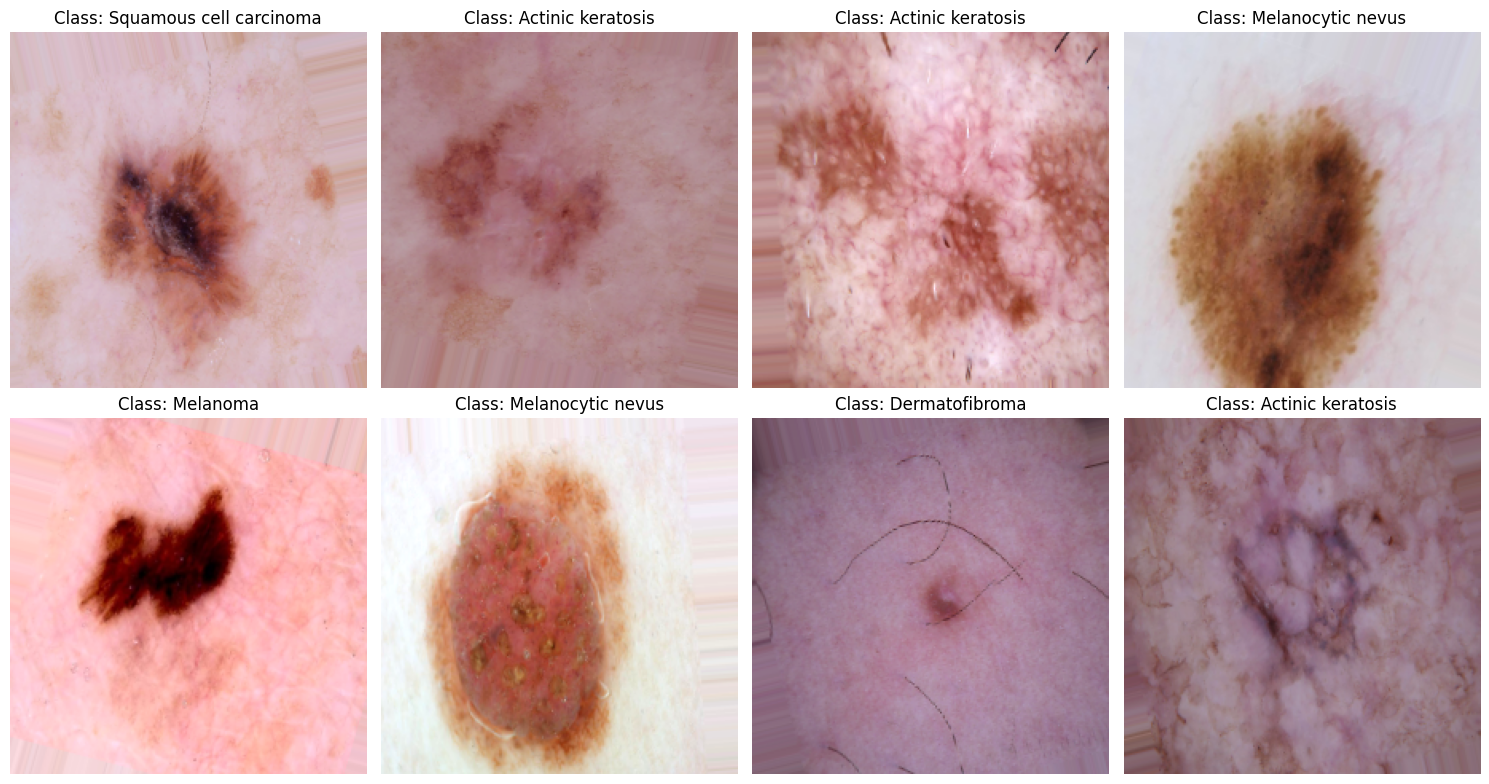

In [ ]:
# CELL 7: CREATE DATA GENERATORS
# =============================================================================

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 9  # Based on your 9 skin conditions

print("🔄 Creating data generators...")
train_generator, val_generator = create_data_generators(
    train_dir, val_dir, IMG_SIZE, BATCH_SIZE
)

print(f"📊 Found {train_generator.samples} training images")
print(f"📊 Found {val_generator.samples} validation images")
print(f"🏷️ Classes: {list(train_generator.class_indices.keys())}")

# Display sample images
def show_sample_images(generator, num_images=8):
    """Show sample images from the generator"""
    # Get a batch of images
    images, labels = next(generator)
    class_names = list(generator.class_indices.keys())

    plt.figure(figsize=(15, 8))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i])
        # Get class name
        class_idx = np.argmax(labels[i])
        plt.title(f'Class: {class_names[class_idx]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print("\n🖼️ Sample training images:")
show_sample_images(train_generator)

In [ ]:
# CELL 8: CREATE AND INSPECT MODELS
# =============================================================================

print("🏗️ Creating models...")
model1 = create_resnet50_model(NUM_CLASSES, (*IMG_SIZE, 3))
model2 = create_custom_cnn_attention_model(NUM_CLASSES, (*IMG_SIZE, 3))

print(f"🔢 ResNet50 Model - Total params: {model1.count_params():,}")
print(f"🔢 Custom CNN Model - Total params: {model2.count_params():,}")

# Display model summaries
print("\n📋 ResNet50 Model Summary:")
model1.summary()

print("\n📋 Custom CNN with Attention Model Summary:")
model2.summary()

🏗️ Creating models...
🔢 ResNet50 Model - Total params: 24,778,633
🔢 Custom CNN Model - Total params: 5,097,916

📋 ResNet50 Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,778,633 (94.52 MB)

 Trainable params: 10,118,153 (38.60 MB)

 Non-trainable params: 14,660,480 (55.93 MB)


📋 Custom CNN with Attention Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 224, 224,  │      1,792 │ input_layer_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_8 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 224, 224,  │     36,928 │ re_lu_8[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        256 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 112, 112,  │          0 │ re_lu_9[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 112, 112,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 112,  │    147,584 │ re_lu_10[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        512 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 56, 56,    │          0 │ re_lu_11[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_13[0][0] 

 Total params: 5,097,916 (19.45 MB)

 Trainable params: 5,094,076 (19.43 MB)

 Non-trainable params: 3,840 (15.00 KB)

🚀 Starting training for Model 1: ResNet50...

🚀 Training ResNet50 Transfer Learning


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.1612 - loss: 2.5551 - precision: 0.2135 - recall: 0.0291
Epoch 1: val_accuracy improved from -inf to 0.11602, saving model to best_resnet50_transfer_learning_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 206s 9s/step - accuracy: 0.1634 - loss: 2.5467 - precision: 0.2144 - recall: 0.0290 - val_accuracy: 0.1160 - val_loss: 2.3479 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.2604 - loss: 2.0410 - precision: 0.4710 - recall: 0.0499
Epoch 2: val_accuracy did not improve from 0.11602
22/22 ━━━━━━━━━━━━━━━━━━━━ 193s 8s/step - accuracy: 0.2606 - loss: 2.0407 - precision: 0.4711 - recall: 0.0500 - val_accuracy: 0.1160 - val_loss: 2.3227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3135 - loss: 1.9401 - precision: 0.5114 - recall: 0.0785
Epoch 3: val_accuracy did not improve from 0.11602
22/22 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.3136 - loss: 1.9392 - precision: 0.5107 - recall: 0.0781 - val_accuracy: 0.1160 - val_loss: 2.3012 - val_precision: 0.0000e+00 - val_rec

22/22 ━━━━━━━━━━━━━━━━━━━━ 186s 9s/step - accuracy: 0.4499 - loss: 1.6970 - precision: 0.6127 - recall: 0.1706 - val_accuracy: 0.1436 - val_loss: 2.2875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4579 - loss: 1.6181 - precision: 0.6080 - recall: 0.1608
Epoch 8: val_accuracy did not improve from 0.14365
22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.4573 - loss: 1.6169 - precision: 0.6109 - recall: 0.1618 - val_accuracy: 0.1326 - val_loss: 2.2853 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4246 - loss: 1.5714 - precision: 0.6784 - recall: 0.1989
Epoch 9: val_accuracy did not improve from 0.14365
22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.4252 - loss: 1.5713 - precision: 0.6775 - recall: 0.1993 - val_accuracy: 0.1215 - val_loss: 2.2755 - val_precision: 0.0000e+00 - val_rec

22/22 ━━━━━━━━━━━━━━━━━━━━ 186s 8s/step - accuracy: 0.5678 - loss: 1.2473 - precision: 0.7388 - recall: 0.3572 - val_accuracy: 0.1602 - val_loss: 2.2111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-05
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5441 - loss: 1.2781 - precision: 0.7322 - recall: 0.3598
Epoch 15: val_accuracy improved from 0.16022 to 0.26519, saving model to best_resnet50_transfer_learning_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.5438 - loss: 1.2802 - precision: 0.7315 - recall: 0.3592 - val_accuracy: 0.2652 - val_loss: 2.1488 - val_precision: 1.0000 - val_recall: 0.0055 - learning_rate: 5.0000e-05
Epoch 16/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5309 - loss: 1.2767 - precision: 0.6788 - recall: 0.3186
Epoch 16: val_accuracy improved from 0.26519 to 0.27624, saving model to best_resnet50_transfer_learning_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.5312 - loss: 1.2756 - precision: 0.6811 - recall: 0.3199 - val_accuracy: 0.2762 - val_loss: 2.1181 - val_precision: 1.0000 - val_recall: 0.0055 - learning_rate: 5.0000e-05
Epoch 17/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5672 - loss: 1.2350 - precision: 0.7857 - recall: 0.3623
Epoch 17: val_accuracy did not improve from 0.27624
22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.5668 - loss: 1.2356 - precision: 0.7839 - recall: 0.3618 - val_accuracy: 0.2541 - val_loss: 2.1417 - val_precision: 1.0000 - val_recall: 0.0166 - learning_rate: 5.0000e-05
Epoch 18/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5622 - loss: 1.2369 - precision: 0.7359 - recall: 0.3664
Epoch 18: val_accuracy improved from 0.27624 to 0.29282, saving model to best_resnet50_transfer_learning_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.5624 - loss: 1.2362 - precision: 0.7360 - recall: 0.3662 - val_accuracy: 0.2928 - val_loss: 1.9804 - val_precision: 1.0000 - val_recall: 0.0442 - learning_rate: 5.0000e-05
Epoch 19/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6060 - loss: 1.1421 - precision: 0.7632 - recall: 0.3943
Epoch 19: val_accuracy did not improve from 0.29282
22/22 ━━━━━━━━━━━━━━━━━━━━ 191s 9s/step - accuracy: 0.6054 - loss: 1.1437 - precision: 0.7630 - recall: 0.3942 - val_accuracy: 0.2044 - val_loss: 1.9552 - val_precision: 1.0000 - val_recall: 0.0718 - learning_rate: 5.0000e-05
Epoch 20/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5689 - loss: 1.1869 - precision: 0.7267 - recall: 0.3940
Epoch 20: val_accuracy did not improve from 0.29282
22/22 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.5692 - loss: 1.1871 - precision: 0.7278 - recall: 0.3946 - val_accuracy: 0.2652 - val_loss: 2.1551 - val_precision: 0.8182 - val_recall: 0.1492 - le

22/22 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.5791 - loss: 1.1998 - precision: 0.7515 - recall: 0.4070 - val_accuracy: 0.3260 - val_loss: 1.9482 - val_precision: 0.7000 - val_recall: 0.1547 - learning_rate: 5.0000e-05
Epoch 22/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5526 - loss: 1.2476 - precision: 0.7164 - recall: 0.3940
Epoch 22: val_accuracy did not improve from 0.32597
22/22 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.5525 - loss: 1.2466 - precision: 0.7166 - recall: 0.3940 - val_accuracy: 0.2431 - val_loss: 2.0067 - val_precision: 0.5806 - val_recall: 0.0994 - learning_rate: 5.0000e-05
Epoch 23/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5943 - loss: 1.1677 - precision: 0.7202 - recall: 0.3876
Epoch 23: val_accuracy did not improve from 0.32597
22/22 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.5944 - loss: 1.1665 - precision: 0.7206 - recall: 0.3884 - val_accuracy: 0.1878 - val_loss: 2.3002 - val_precision: 0.2020 - val_recall: 0.1105 - le

22/22 ━━━━━━━━━━━━━━━━━━━━ 191s 8s/step - accuracy: 0.5821 - loss: 1.1626 - precision: 0.7289 - recall: 0.4147 - val_accuracy: 0.3702 - val_loss: 1.8213 - val_precision: 0.5192 - val_recall: 0.2983 - learning_rate: 2.5000e-05
Epoch 31/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6222 - loss: 1.0598 - precision: 0.7743 - recall: 0.4934
Epoch 31: val_accuracy did not improve from 0.37017
22/22 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.6214 - loss: 1.0602 - precision: 0.7730 - recall: 0.4920 - val_accuracy: 0.3370 - val_loss: 2.0954 - val_precision: 0.3359 - val_recall: 0.2376 - learning_rate: 2.5000e-05
Epoch 32/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5898 - loss: 1.1173 - precision: 0.7471 - recall: 0.4487
Epoch 32: val_accuracy did not improve from 0.37017
22/22 ━━━━━━━━━━━━━━━━━━━━ 183s 8s/step - accuracy: 0.5905 - loss: 1.1143 - precision: 0.7471 - recall: 0.4490 - val_accuracy: 0.3536 - val_loss: 1.8636 - val_precision: 0.4433 - val_recall: 0.2376 - le

22/22 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.6305 - loss: 0.9980 - precision: 0.7632 - recall: 0.4711 - val_accuracy: 0.3867 - val_loss: 2.7462 - val_precision: 0.4257 - val_recall: 0.3481 - learning_rate: 1.2500e-05
Epoch 37/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6359 - loss: 0.9475 - precision: 0.7579 - recall: 0.5136
Epoch 37: val_accuracy improved from 0.38674 to 0.45856, saving model to best_resnet50_transfer_learning_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.6359 - loss: 0.9478 - precision: 0.7586 - recall: 0.5133 - val_accuracy: 0.4586 - val_loss: 1.7742 - val_precision: 0.6083 - val_recall: 0.4033 - learning_rate: 1.2500e-05
Epoch 38/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6640 - loss: 0.9276 - precision: 0.8017 - recall: 0.5070
Epoch 38: val_accuracy improved from 0.45856 to 0.53039, saving model to best_resnet50_transfer_learning_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 188s 9s/step - accuracy: 0.6642 - loss: 0.9283 - precision: 0.8008 - recall: 0.5071 - val_accuracy: 0.5304 - val_loss: 1.3805 - val_precision: 0.6560 - val_recall: 0.4530 - learning_rate: 1.2500e-05
Epoch 39/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6615 - loss: 0.9949 - precision: 0.7927 - recall: 0.5205
Epoch 39: val_accuracy did not improve from 0.53039
22/22 ━━━━━━━━━━━━━━━━━━━━ 184s 8s/step - accuracy: 0.6606 - loss: 0.9950 - precision: 0.7918 - recall: 0.5201 - val_accuracy: 0.5193 - val_loss: 1.5755 - val_precision: 0.6288 - val_recall: 0.4586 - learning_rate: 1.2500e-05
Epoch 40/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6145 - loss: 1.0060 - precision: 0.7216 - recall: 0.5018
Epoch 40: val_accuracy did not improve from 0.53039
22/22 ━━━━━━━━━━━━━━━━━━━━ 197s 9s/step - accuracy: 0.6153 - loss: 1.0038 - precision: 0.7225 - recall: 0.5024 - val_accuracy: 0.4917 - val_loss: 1.8462 - val_precision: 0.5473 - val_recall: 0.4475 - le

22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.6523 - loss: 0.9612 - precision: 0.7471 - recall: 0.5138 - val_accuracy: 0.5580 - val_loss: 1.3687 - val_precision: 0.7097 - val_recall: 0.4862 - learning_rate: 6.2500e-06
Epoch 46/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6677 - loss: 0.8739 - precision: 0.7693 - recall: 0.5512
Epoch 46: val_accuracy did not improve from 0.55801
22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.6664 - loss: 0.8777 - precision: 0.7684 - recall: 0.5499 - val_accuracy: 0.5249 - val_loss: 1.6081 - val_precision: 0.5891 - val_recall: 0.4199 - learning_rate: 6.2500e-06
Epoch 47/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6573 - loss: 0.9335 - precision: 0.7720 - recall: 0.5207
Epoch 47: val_accuracy did not improve from 0.55801
22/22 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.6580 - loss: 0.9319 - precision: 0.7726 - recall: 0.5212 - val_accuracy: 0.4420 - val_loss: 1.9027 - val_precision: 0.5036 - val_recall: 0.3867 - le

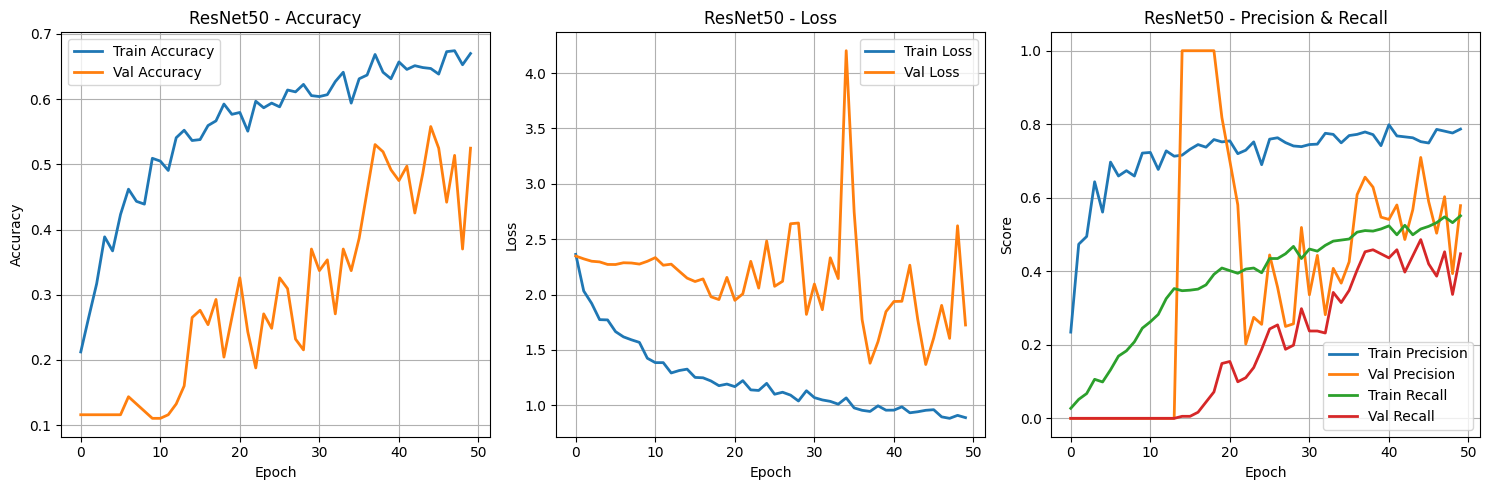

✅ Model 1 training completed!


In [ ]:
# CELL 9: TRAIN MODEL 1 (RESNET50)
# =============================================================================

print("🚀 Starting training for Model 1: ResNet50...")
history1 = train_model(model1, train_generator, val_generator,
                      "ResNet50 Transfer Learning", EPOCHS)

# Plot training history for Model 1
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history1.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history1.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('ResNet50 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history1.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history1.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('ResNet50 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history1.history['precision'], label='Train Precision', linewidth=2)
plt.plot(history1.history['val_precision'], label='Val Precision', linewidth=2)
plt.plot(history1.history['recall'], label='Train Recall', linewidth=2)
plt.plot(history1.history['val_recall'], label='Val Recall', linewidth=2)
plt.title('ResNet50 - Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("✅ Model 1 training completed!")

🚀 Starting training for Model 2: Custom CNN with Attention...

🚀 Training Custom CNN Attention


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - accuracy: 0.1450 - loss: 2.2535 - precision: 0.5667 - recall: 0.0159 
Epoch 1: val_accuracy improved from -inf to 0.12155, saving model to best_custom_cnn_attention_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1337s 60s/step - accuracy: 0.1472 - loss: 2.2485 - precision: 0.5599 - recall: 0.0162 - val_accuracy: 0.1215 - val_loss: 2.2210 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - accuracy: 0.3099 - loss: 1.8390 - precision: 0.5185 - recall: 0.0687 
Epoch 2: val_accuracy did not improve from 0.12155
22/22 ━━━━━━━━━━━━━━━━━━━━ 1383s 63s/step - accuracy: 0.3085 - loss: 1.8387 - precision: 0.5170 - recall: 0.0687 - val_accuracy: 0.0994 - val_loss: 2.3191 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - accuracy: 0.3455 - loss: 1.7156 - precision: 0.5206 - recall: 0.0935 
Epoch 3: val_accuracy did not improve from 0.12155
22/22 ━━━━━━━━━━━━━━━━━━━━ 1348s 61s/step - accuracy: 0.3451 - loss: 1.7153 - precision: 0.5206 - recall: 0.0937 - val_accuracy: 0.1105 - val_loss: 2.5541 - val_precision: 0.0000e+00 - val_r

22/22 ━━━━━━━━━━━━━━━━━━━━ 1302s 59s/step - accuracy: 0.3970 - loss: 1.5233 - precision: 0.5154 - recall: 0.1505 - val_accuracy: 0.1381 - val_loss: 2.4401 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - accuracy: 0.4249 - loss: 1.4137 - precision: 0.5818 - recall: 0.1927 
Epoch 9: val_accuracy did not improve from 0.13812
22/22 ━━━━━━━━━━━━━━━━━━━━ 1304s 59s/step - accuracy: 0.4245 - loss: 1.4138 - precision: 0.5820 - recall: 0.1926 - val_accuracy: 0.0773 - val_loss: 3.0145 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - accuracy: 0.4031 - loss: 1.4870 - precision: 0.5306 - recall: 0.1888 
Epoch 10: val_accuracy improved from 0.13812 to 0.16575, saving model to best_custom_cnn_attention_model.h5


22/22 ━━━━━━━━━━━━━━━━━━━━ 1299s 59s/step - accuracy: 0.4037 - loss: 1.4867 - precision: 0.5316 - recall: 0.1889 - val_accuracy: 0.1657 - val_loss: 2.5083 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - accuracy: 0.4568 - loss: 1.4040 - precision: 0.6123 - recall: 0.2037 
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 11: val_accuracy did not improve from 0.16575
22/22 ━━━━━━━━━━━━━━━━━━━━ 1295s 59s/step - accuracy: 0.4573 - loss: 1.4024 - precision: 0.6128 - recall: 0.2042 - val_accuracy: 0.1050 - val_loss: 2.9603 - val_precision: 0.2500 - val_recall: 0.0110 - learning_rate: 5.0000e-04
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 1.


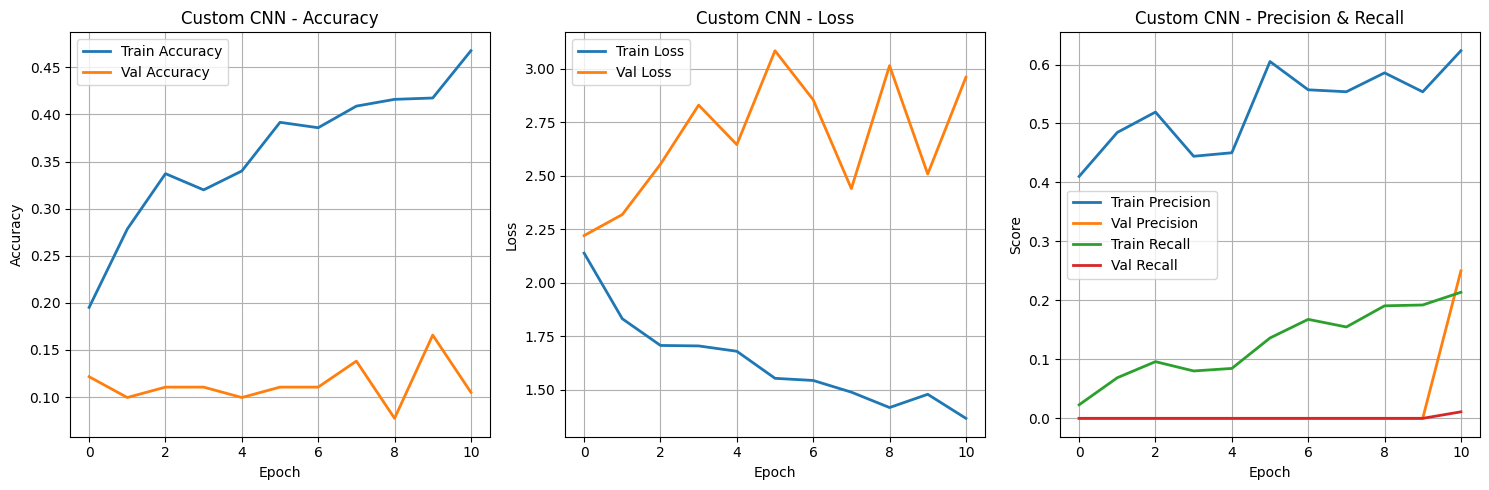

✅ Model 2 training completed!


In [26]:
# CELL 10: TRAIN MODEL 2 (CUSTOM CNN WITH ATTENTION)
# =============================================================================

print("🚀 Starting training for Model 2: Custom CNN with Attention...")
history2 = train_model(model2, train_generator, val_generator,
                      "Custom CNN Attention", EPOCHS)

# Plot training history for Model 2
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history2.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Custom CNN - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history2.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history2.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Custom CNN - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history2.history['precision'], label='Train Precision', linewidth=2)
plt.plot(history2.history['val_precision'], label='Val Precision', linewidth=2)
plt.plot(history2.history['recall'], label='Train Recall', linewidth=2)
plt.plot(history2.history['val_recall'], label='Val Recall', linewidth=2)
plt.title('Custom CNN - Precision & Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("✅ Model 2 training completed!")


🎯 FINAL EVALUATION RESULTS

🔍 Evaluating ResNet50 Transfer Learning...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step

📊 ResNet50 Transfer Learning - Classification Report
                            precision    recall  f1-score   support

         Actinic keratosis     0.0000    0.0000    0.0000        20
         Atopic Dermatitis     0.0000    0.0000    0.0000        21
          Benign keratosis     0.0000    0.0000    0.0000        20
            Dermatofibroma     0.1105    1.0000    0.1990        20
         Melanocytic nevus     0.0000    0.0000    0.0000        20
                  Melanoma     0.0000    0.0000    0.0000        20
   Squamous cell carcinoma     0.0000    0.0000    0.0000        20
Tinea Ringworm Candidiasis     0.0000    0.0000    0.0000        20
           Vascular lesion     0.0000    0.0000    0.0000        20

                  accuracy                         0.1105       181
                 macro avg     0.0123    0.1111    0.0221       181
              weighted avg     0.0122    0.1105    0.0220       181



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


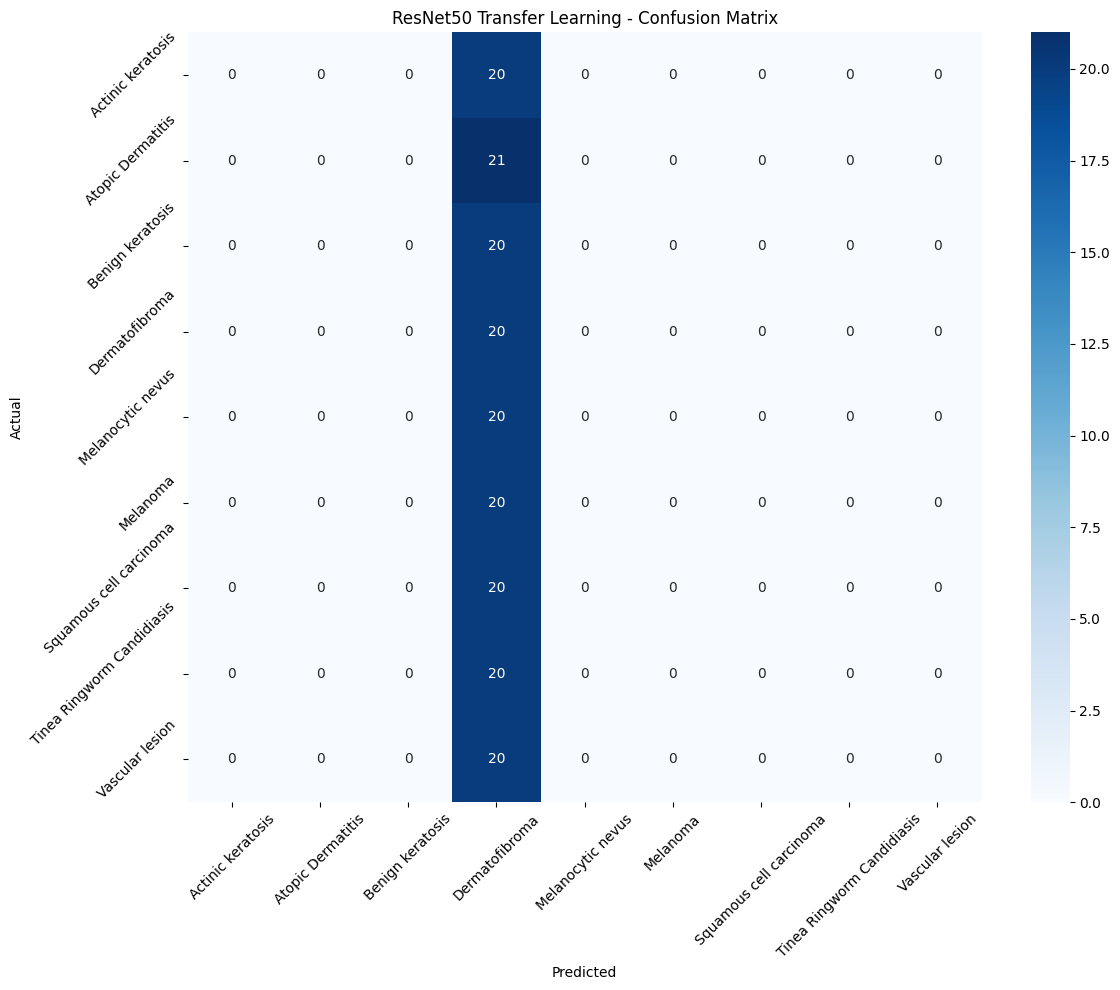


🔍 Evaluating Custom CNN with Attention...
6/6 ━━━━━━━━━━━━━━━━━━━━ 105s 18s/step

📊 Custom CNN with Attention - Classification Report
                            precision    recall  f1-score   support

         Actinic keratosis     0.0000    0.0000    0.0000        20
         Atopic Dermatitis     0.1061    0.9048    0.1900        21
          Benign keratosis     0.0000    0.0000    0.0000        20
            Dermatofibroma     0.0000    0.0000    0.0000        20
         Melanocytic nevus     0.0000    0.0000    0.0000        20
                  Melanoma     0.0000    0.0000    0.0000        20
   Squamous cell carcinoma     0.0000    0.0000    0.0000        20
Tinea Ringworm Candidiasis     0.0000    0.0000    0.0000        20
           Vascular lesion     0.0000    0.0000    0.0000        20

                  accuracy                         0.1050       181
                 macro avg     0.0118    0.1005    0.0211       181
              weighted avg     0.0123    0.1050

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


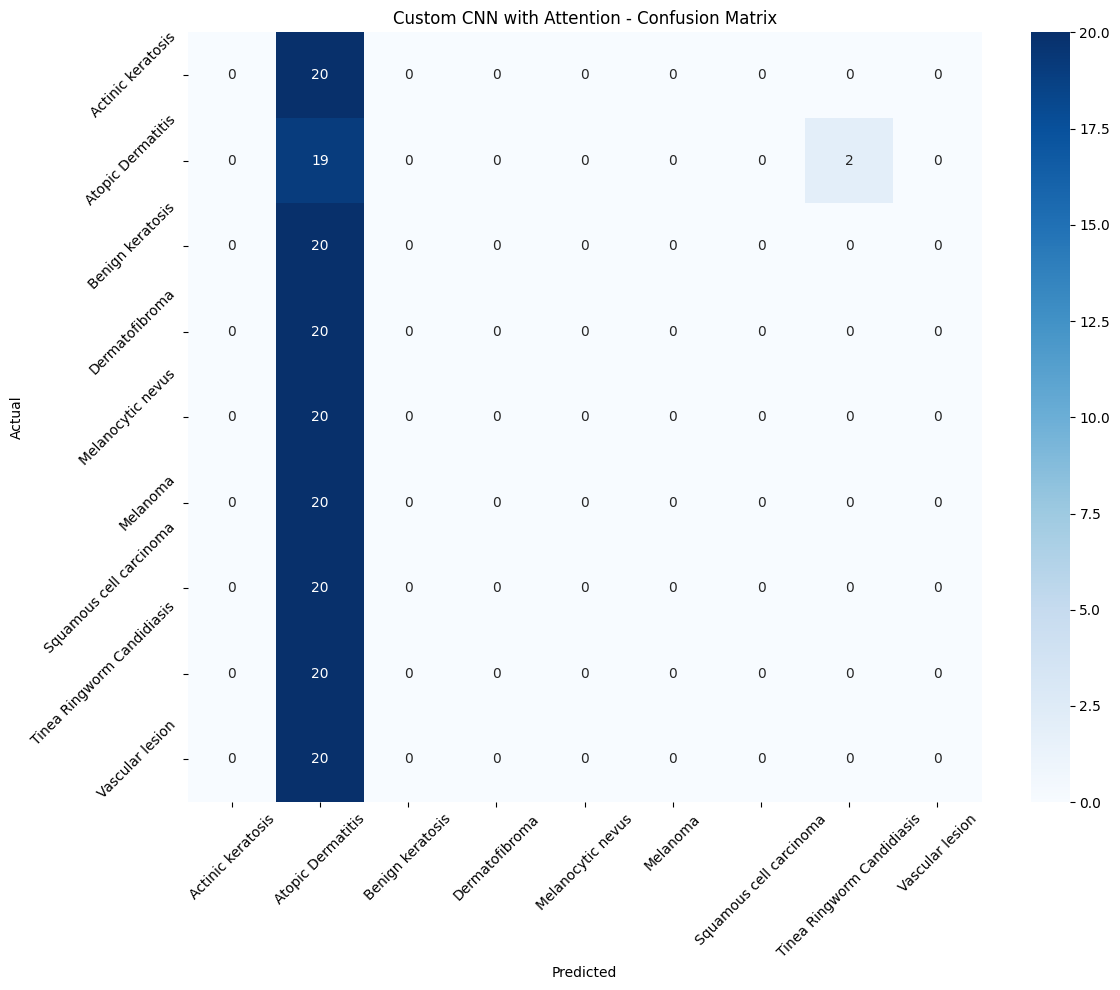

In [ ]:
# CELL 11: EVALUATE BOTH MODELS
# =============================================================================

print("\n" + "="*80)
print("🎯 FINAL EVALUATION RESULTS")
print("="*80)

# Evaluate Model 1
preds1, pred_classes1 = evaluate_model(model1, val_generator, "ResNet50 Transfer Learning")

# Evaluate Model 2
preds2, pred_classes2 = evaluate_model(model2, val_generator, "Custom CNN with Attention")

In [ ]:
# CELL 12: COMPARE MODELS AND VISUALIZE RESULTS
# =============================================================================

# Plot training history comparison
plot_training_history(history1, history2, "ResNet50", "Custom CNN")

# Calculate and display final accuracies
val_generator.reset()
final_acc_1 = model1.evaluate(val_generator, verbose=0)[1]
val_generator.reset()
final_acc_2 = model2.evaluate(val_generator, verbose=0)[1]

print("\n" + "="*60)
print("🏆 FINAL RESULTS SUMMARY")
print("="*60)
print(f"ResNet50 Transfer Learning - Final Validation Accuracy: {final_acc_1:.4f}")
print(f"Custom CNN with Attention - Final Validation Accuracy: {final_acc_2:.4f}")

if final_acc_1 > final_acc_2:
    print(f"🥇 Winner: ResNet50 Transfer Learning (+{final_acc_1-final_acc_2:.4f})")
else:
    print(f"🥇 Winner: Custom CNN with Attention (+{final_acc_2-final_acc_1:.4f})")

# Create summary comparison chart
models = ['ResNet50\nTransfer Learning', 'Custom CNN\nwith Attention']
accuracies = [final_acc_1, final_acc_2]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 1])

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

NameError: name 'history1' is not defined